In [ ]:
# @title Copyright & License (click to expand)
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI LLM Evaluation & Batch Inference

<table align="left">
  <td>
    <a href="https://colab.sandbox.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/generative_ai/batch_eval_llm.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/generative_ai/batch_eval_llm.ipynb">
        <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
    <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/generative_ai/batch_eval_llm.ipynb">
       <img src="https://www.gstatic.com/cloud/images/navigation/vertex-ai.svg" alt="Vertex AI logo">Open in Vertex AI Workbench
    </a>
</table>

## Overview

This tutorial demonstrates how to evaluate a large-language model (LLM) end-to-end with Vertex AI.

*Preview releases are covered by the Pre-GA Offerings Terms of the Google Cloud Platform Terms of Service. They are not intended for production use or covered by any SLA, support obligation, or deprecation policy and might be subject to backward-incompatible changes.*

Learn more about [Overview of Generative AI support on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview).

### Objective

In this tutorial, you learn to use Vertex AI to evaluate a large language model.

This tutorial uses the following Google Cloud ML services:

- `Vertex AI Pipelines`

The steps performed include:

- Create Vertex AI Pipeline job using a predefined template for bulk inference.
- Execute the pipeline using Vertex AI Pipelines.
- Produce prediction results against a model for a given dataset.

### Prepare your inputs

In the sample below, you will run Bulk Inference on Google PaLM 2 Bison model using v3 TPU Pod. A list of supported models, hardware and regions can be found as follows. Tuning jobs that run in us-central1 will use 8 Nvidia A100 80GB. Jobs that run in europe-west4 will use 32 v3 TPUs.

**Table 1. Supported models, hardware and regions**

| large_model_reference | supported accelerator_type | supported region |
|---|---|---|
|  `text-bison@001` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |
|  `chat-bison@001` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |
|  `t5-small` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |
|  `t5-large` | `TPU_V3` | europe-west4 |
|  `t5-xl` | `TPU_V3` | europe-west4 |
|  `t5-xxl` | `TPU_V3` | europe-west4 |

The workflow takes the following inputs:

* **prompt_dataset**: Required, `str`. Cloud storage path to an unlabled JSONL dataset that contains prompts used to generate predictions. 
> Datasets used to tune text models must contain an `input_text` field that contains the prompt.
> * For example: `{"input_text": "Create a description for Plantation Palms."}`
> * Download the [sample text dataset](https://pantheon.corp.google.com/storage/browser/vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&e=13802955&jsmode=O&mods=-ai_platform_fake_service&project=vertex-ai&prefix=&forceOnObjectsSortingFiltering=false) to see more examples.

> Datasets used to tune chat models must contain at least 1 message in a `messages` field.
> * Each message must be valid JSON that contains `author` and `content` fields, where valid `author` values are `user` and `assistant` and `content` must be non-empty.
> * Each row may contain multiple messages, but the first and last author must be the `user`.
> * An optional `context` field may be provided for each example in a chat dataset. If provided, the `context` will preprended to the message `content`.
> * The `instruction` serves as the default context. (Useful if most messages use the same system-level context.) Any context provided in the example will override the default value.
> * For example: `{"context": "I am a helpful assistant that can answer questions about Plantation Palms.", "messages": [{"author": "user", "content": "Hello"}, {"author": "assistant", "content": "Hello, how can I help you?"}, {"author": "user", "content": "Tell me about Plantation Palms."}]}`

* **large_model_reference**: Required, `str`. Name of the base model. In this example, we use `text-bison@001`. The valid values are listed in the table above.

* **model_checkpoint**. Optional, `str`. The GCS path to the model's checkpoint. It should be a derivative of the model specified by **large_model_reference**. This can be output of an RLHF training pipeline. The tuned model is stored at the **Reinforcer** > **Output Parameters** > `output_model_path`. If unspecified, the base (i.e. untuned) model corresponding to **large_model_reference** will be used.

* **instruction**: Optional, `str`. This field lets the model know what task it needs to perform. Base models have been trained over a large set of varied instructions. You can give a simple and intuitive description of the task and the model will follow it, e.g. `Classify this movie review as positive or negative` or `Translate this sentence to Danish`. See [here](https://ai.googleblog.com/2021/10/introducing-flan-more-generalizable.html) for more details on the instruction-tuned models. Do not specify this if your dataset already prepends the instruction to the inputs field.

### A Note on designing your prompts

All prompt design techniques can be used with RLHF pipelines. If you are tuning `text-bison@001`, use the prompt that works with the un-tuned model as your `instruction` in the datasets.


### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [ ]:
! pip3 install --upgrade --quiet google-cloud-aiplatform \
                                 google-cloud-pipeline-components \
                                 kfp

### Colab only: Uncomment the following cell to restart the kernel

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

## Before you begin

### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "europe-west4"

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may need to authenticate manually. Follow the relevant instructions below.

#### Vertex AI Workbench
Do nothing as you are already authenticated.

#### Local JupyterLab instance

**1. Uncomment and run:**

In [ ]:
# ! gcloud auth login

**2. Colab, uncomment and run:**

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

**3. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Define a storage bucket to store pipeline artifacts.

In [ ]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

#### Service Account

A service account is needed to create Vertex AI Pipeline jobs. If you don't know your service account, run the following gcloud command to obtain your Compute Engine default service account.

In [ ]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [ ]:
import sys

IS_COLAB = "google.colab" in sys.modules
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    else:  # IS_COLAB:
        shell_output = ! gcloud projects describe $PROJECT_ID --format="value(projectNumber)"
        project_number = shell_output[0]
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step. You only need to run this step once per service account.

In [ ]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries and define constants

In [ ]:
import os

import google.cloud.aiplatform as aiplatform
from google_cloud_pipeline_components.preview.llm import infer_pipeline
from kfp import compiler

## Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [ ]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## Compile the Inference Pipeline

Compile the pipeline into a YAML file that will be submitted to Vertex AI.

In [ ]:
INFER_PIPELINE_PKG_PATH = "infer_pipeline.yaml"

compiler.Compiler().compile(
    pipeline_func=infer_pipeline, package_path=INFER_PIPELINE_PKG_PATH
)

## Construct the Pipeline Job and Run on Vertex AI

Define a pipeline job with the following code, which will:

- load the pipeline template that was compiled in the previous step, and
- set the pipeline parameters. 


In [ ]:
PIPELINE_ROOT = f"{BUCKET_URI}/tutorial-infer-eval"

# This path is the text-bison@001 checkpoint. If you want to evaluate your own tuned
# model, PLEASE substitute this path with your own tuned checkpoint from the
# RLHF training pipeline. The tuned model is stored at the Reinforcer > Output Parameters > output_model_path.
# It is usually something that begins with gs://caip-tenant-*.
MODEL_CHECKPOINT = "gs://vertex-rlhf-restricted/pretrained_models/palm/t5x_bison"

# Create a job via the pipeline template
job = aiplatform.PipelineJob(
    display_name="tutorial-infer-eval",
    pipeline_root=PIPELINE_ROOT,
    template_path=INFER_PIPELINE_PKG_PATH,
    parameter_values={
        "large_model_reference": "text-bison@001",  # see Table 1 for valid values.
        "model_checkpoint": MODEL_CHECKPOINT,
        "prompt_dataset": "gs://cloud-samples-data/vertex-ai/llm/rlhf/text_small/reddit_tfds/val/*.jsonl",
        "instruction": "Summarize in less than 50 words.",
    },
)

### Run the pipeline using Vertex AI Pipelines

Execute the following cell to run the pipeline on Vertex AI.

In [ ]:
job.run()

## View the inference result

Go to "Vertex AI Pipelines" in the Google Cloud UI to view the pipeline job. When the pipeline completes, click on **Bulk Inferrer** > **Output Parameters** > `output_prediction_gcs_path`. If you encounter "❗ Requested entity was not found", this is a known issue. Hit the backarrow at the top of the page, you will see your inference results there.

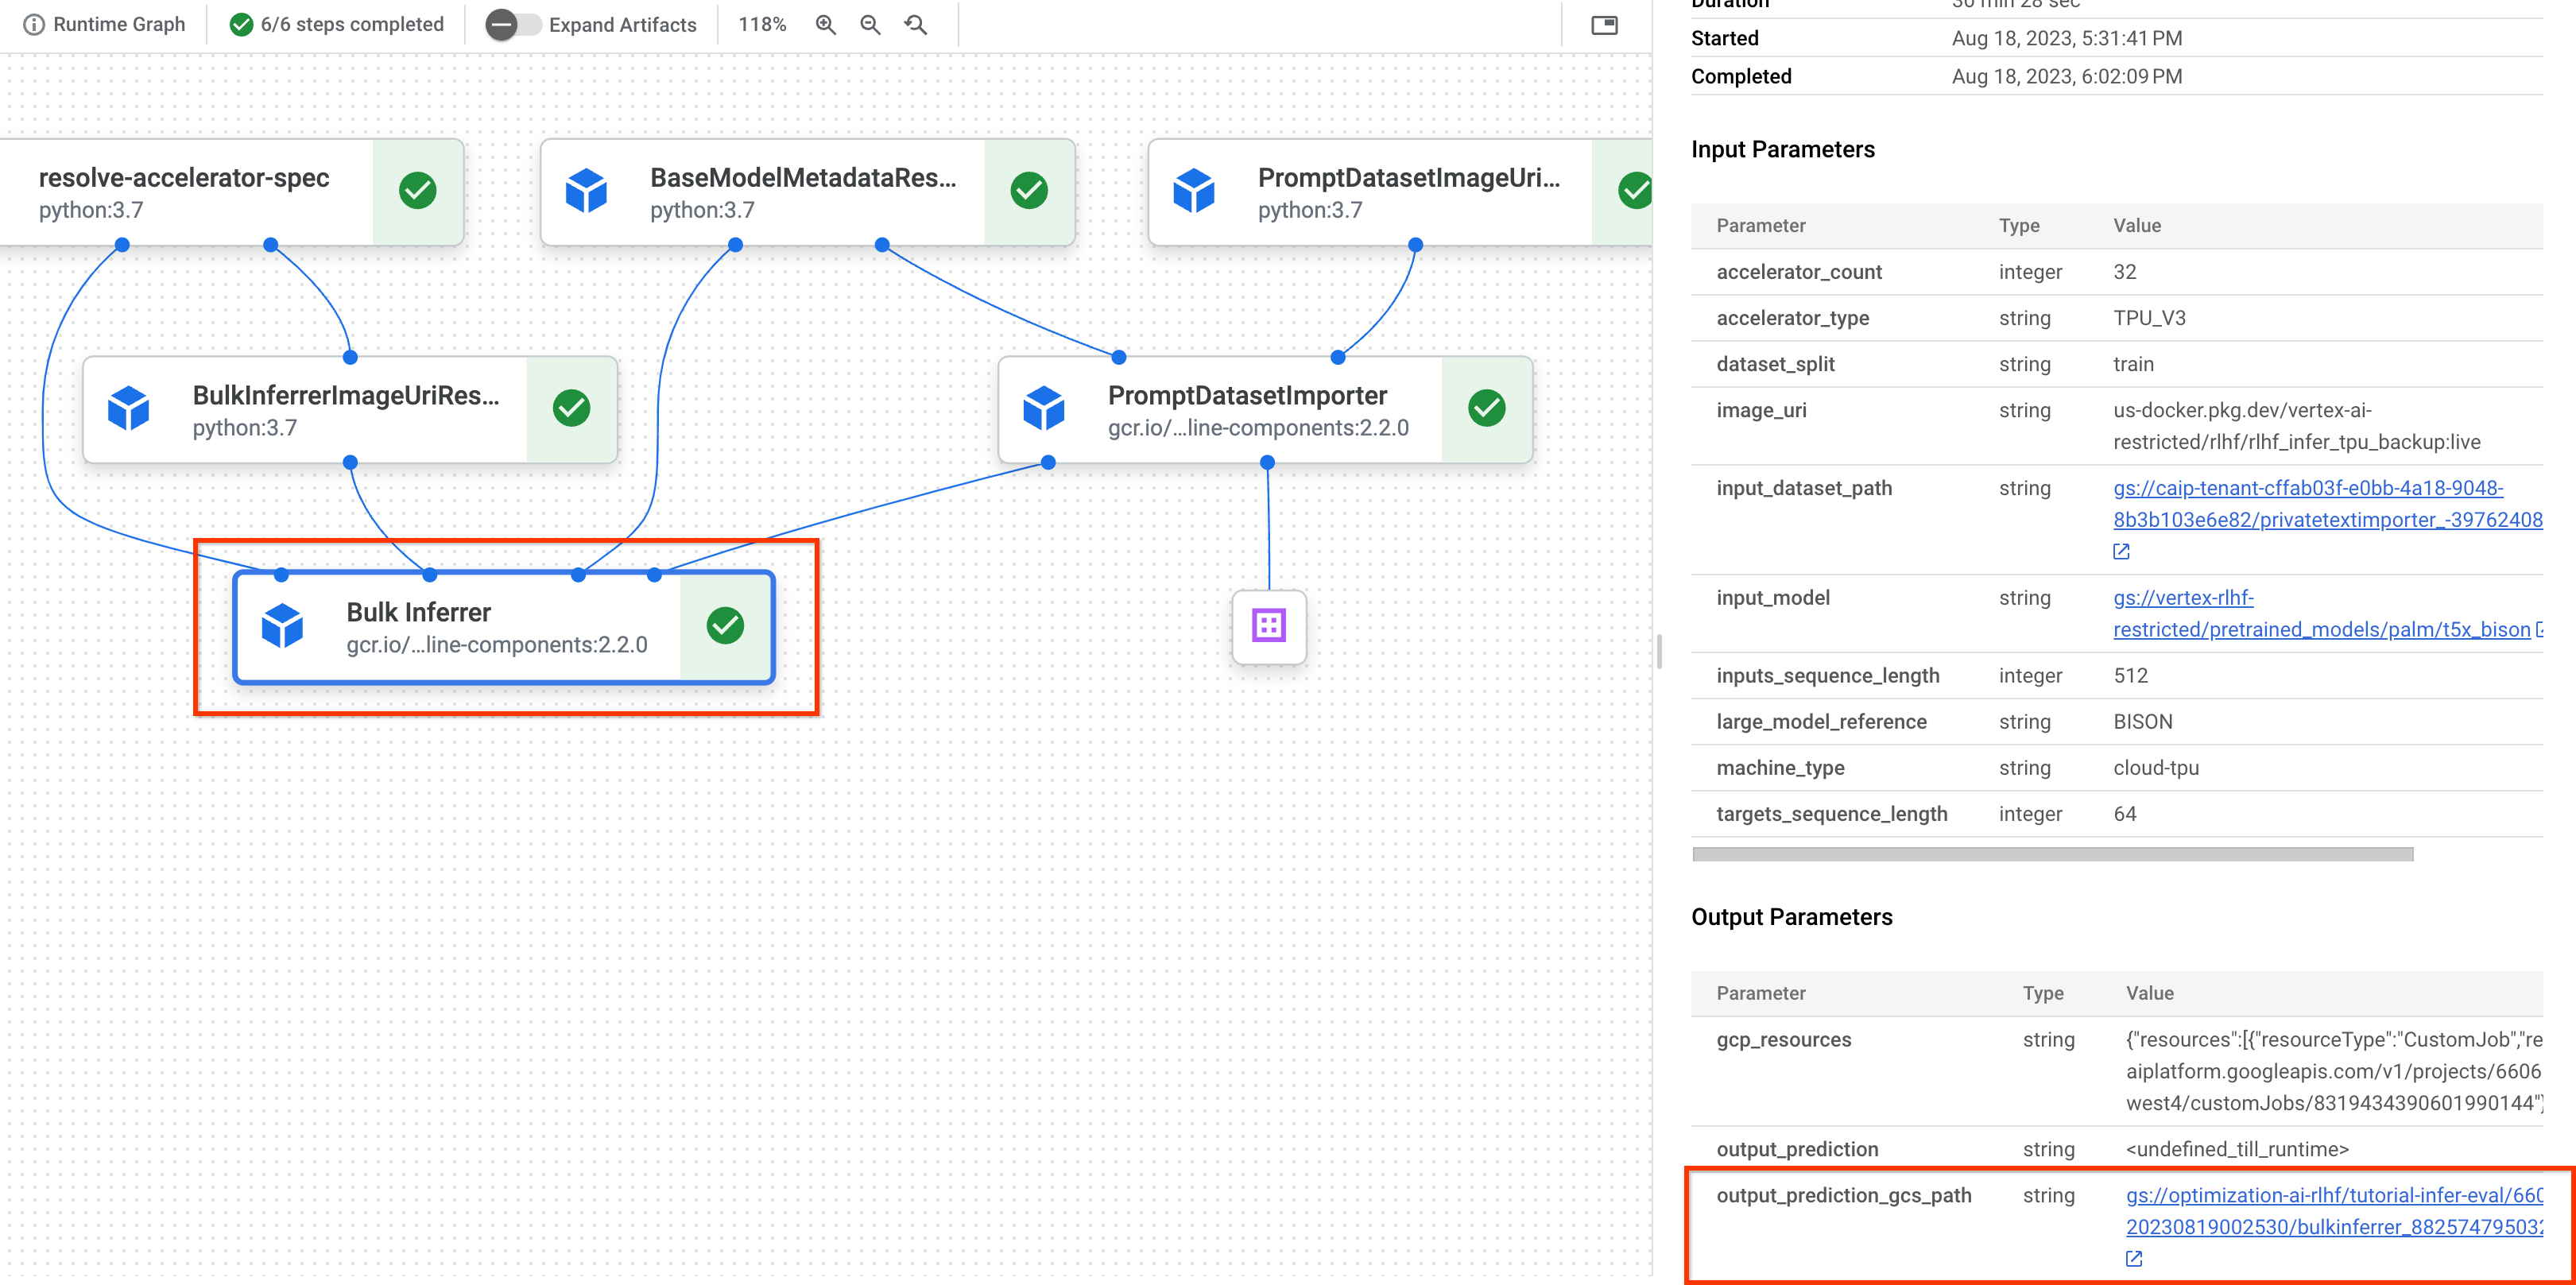

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [ ]:
delete_bucket = False

job.delete()

if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -rf {BUCKET_URI}

! rm infer_pipeline.yaml